# Technical Challenge - Data Science
Part of an intership process in data analysis onBirdie, a startup that works to generate practical insights about consumers' experience with products, brands and sales channels during the buying journey, allowing companies to have a clear vision of where and how they can improve their procedures.

---

## 1. Goal
*Extract aspects* from a well structured review dataset and *provide insights* over the discoveries, optionally generating charts and other visual information to present these perceptions.

## 2. Dataset
User reviews related to refrigerators collected between 2019 and 2020 on e-commerce sites. The dataset is available at *tech_test.tsv*.

In [1]:
import re
import json
import nltk
import codecs
import string
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict

In [2]:
data = pd.read_csv('input/tech_test.tsv')
# data.head()

In [3]:
features = list(data.columns)
print("Number of Attributes: {}".format(len(features)))
print("Attributes:\n {}".format(features))

Number of Attributes: 25
Attributes:
 ['retailer', 'category', 'breadcrumb', 'brand', 'offer_url', 'offer_sku', 'offer_retailer', 'offer_title', 'title_keywords', 'price', 'specs', 'offer_last_update_at', 'review_id', 'review_title', 'review_body', 'review_user_rating', 'review_posted_at', 'review_year', 'review_month', 'review_week', 'review_day', 'review_collected_at', 'locale', 'original_offer', 'variant']


### 2.1. Overview
The dataset contains 25 attributes that can be splitted into three categories: general, offer and review.

- **General**: refers to some basic informations as the product category (refrigerator) and the website where the client bought it.
- **Offer**: info related to the offer, like its code(sku), brand, title, specifications and last update date.
- **Review**: indicates the review data such as title, body, rating, posting date.

Most of the insights that we can infer, based on the provided data, will fall within the last two categories and our main objective (aspect extraction) is closely related to the customer reviews' category, more specifically in its *title* and *body*.

## 3. Analyzing possible methods to perform the task
Aspect extraction is one of the key tasks in sentiment analysis and it aims to extract entity aspects on
which opinions have been expressed. One of the earliest studies that directly addressed this problem was 'Mining and Summarizing Customer Reviews' (Hu & Liu, 2004), they used a set of rules based on statistical observations and created some distinctions (explicit vs. implicit aspects) that are still applied these days.

At present, the most efficient and popular techniques are based in machine learning and neural network models, and, generally, they can be performed using supervised or unsupervised methods. Most of supervised systems consider aspect extration as a labelling problem and some of the state of the art processes are hidden Markov models (HMM), conditional random fields (CRF), recurrent neural networks (RNN) and, most recently, Convolutional Neural Networks(CNN). As for the unsupervised category, latent Dirichlet allocation (LDA) have become the dominant approach for aspect extraction  and also, recently, a restricted Boltzmann machine (RBM)-based model was proposed (Wang et. al, 2015) to simultaneously extract aspects and relevant sentiments of a given review sentence, however a novel procedure is gaining ground, attention-based mechanisms, which create simple and efficient models, its idea is to de-emphasize irrelevant words during training based on attention functions.

Now, relating those methods with our main task we could reach some conclusions: at first CNN approaches sounded like a nice direction to follow (coherent, few layers), but annotated (labeled) data is scarse in the target dataset domain, we couldn't find them in any data repository online and attributing the labels manually would be very time consuming. So, due to the lack of additional information, we changed our focus to the unsupervised methods and, as attention-based models were recurrent in latest research, it seemed like a nice challenge to implement one of them.

## 4. Attention-based Aspect Extraction (ABAE) Model
For this data challenge, we chose to implement the ABAE model (He et. al, 2017), which ultimate goal is to learn a set of aspect embeddings, based on a word embedding space and an attention mechanism. The model start by creating feature vectors of words in a embedding space to correlate the ones that appear in a similar context. Then, attention mechanisms can be applied to de-emphasize irrelevant words in this embedding, they do that by capturing the global context of a sentence through the average of its words and associate this global embedding with each word embedding to apprehend the word relevance. Afterwards, it applies a sentence reconstruction by evaluating each sentence based on aspect embeddings features and weight vectors, this embeddings are the ones that need to be fine-tuned. The model is trained to minimize the reconstruction error by making the reconstructed embedding similar to the target sentence embedding while different from some negative instances. Therefore, the model can be applied to test sentences with the best parameters found.

### 4.1. Preprocessing
In this first step, we are going to clean and adjust the reviews so they can achieve a better result when we apply the method. To combine all the information that we need in a single data structure, we are going to concatenate the title and the body from the reviews in a new list. After that we can remove all unwanted characters/symbols, transform the sentences to lowercase and apply a lemmatization and tokenization processes.

In [4]:
review_title = list(data.review_title)
review_body = list(data.review_body)

reviews = [str(i) + '. ' + str(j) for i , j in zip(review_title, review_body)]

In [5]:
filtered_reviews = []
for s in reviews:
    s = re.sub('[\[\]\r\t\n]', '', s).lower()         # remove space, newline, tab and other unwanted chars
    s = re.sub(r'[^\x00-\x7F]','', s)                 # remove non-ASCII characters
    filtered_reviews.append(s)

# It's important to remove duplicated reviews, otherwise nouns appearing
# in those reviews would have advantage over others (unfair counting)     
filtered_reviews = list(set(filtered_reviews)) 

In [6]:
out = codecs.open('data/tech_test.txt', 'w', 'utf-8')

punct = '[' + string.punctuation + ']'                      # regex expression to be used in re.sub function

corpus = []
for review in filtered_reviews:
    sentences = nltk.tokenize.sent_tokenize(review)         # tokenize reviews into sentences
    for sent in sentences:
        sent = re.sub(punct, '', sent)
        tokens = nltk.tokenize.word_tokenize(sent)          # then, tokenize these sentences into words
        tokens = [w for w in tokens if w.isalpha()]         # remove words with non alphabetic chars
        if len(tokens) > 3:                                 # remove sentences that are too short
            out.write(' '.join(tokens)+'\n')
            corpus.append(tokens)

### 4.2. Applying the model
Since we are not interested in assigning labels to major aspects(topics) that we found, we can concentrate only in the model's features related to our main task. In order to perform that, we simply need to store the best model configuration in the training phase in order to detect the aspect terms for the test corpus later, both steps (train and test) are implemented and described in the next subsections. The functions defined below are responsible for: reading the input data (domain and test corpus) as well as creating a vocab index; determining a sentence and negative instances that will compose the batches; defining the loss function and the main model function, which creates a Keras model and bootstrap its layers.

In [7]:
import keras.backend as K
import keras.optimizers as opt
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import sequence
from keras.layers import Dense, Activation, Embedding, Input
from model_layers import Attention, Average, WeightedSum, WeightedAspectEmb, MaxMargin, W2VEmbReader

Using TensorFlow backend.
C:\Users\Marcos Wendell\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Marcos Wendell\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Marcos Wendell\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [8]:
EPOCHS = 15
NEG_SIZE = 20
EMB_DIM = 200
MAX_LEN = 50
BATCH_SIZE = 50
ORTHO_REG = 0.1
ASPECT_SIZE = 14
VOCAB_SIZE = 100000

def create_vocab(source, maxlen):
    f = codecs.open(source, 'r', 'utf-8')
    
    word_freqs = Counter()
    for line in f:
        words = line.split()
        
        # Sentences with more than maxlen words are ignored
        if len(words) > maxlen:
            continue

        for w in words:
            if not w.isnumeric():
                word_freqs[w] += 1
                
    sorted_word_freqs = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)

    vocab = {'<pad>':0, '<unk>':1, '<num>':2}
    index = len(vocab)
    for word, _ in sorted_word_freqs:
        vocab[word] = index
        index += 1
        if index > VOCAB_SIZE + 2:
            break

    return vocab

def get_data(source, vocab, max_len):
    maxlen = 0
    f = codecs.open(source, 'r', 'utf-8')

    data = []
    for line in f:
        words = line.strip().split()
        
        # Sentences with more than maxlen words are ignored
        if len(words) > max_len:
            continue
        
        indices = []
        for word in words:
            if word.isnumeric():
                indices.append(vocab['<num>'])
            elif word in vocab:
                indices.append(vocab[word])
            else:
                indices.append(vocab['<unk>'])

        data.append(indices)
        if maxlen < len(indices):
            maxlen = len(indices)
    
    return data, maxlen

def load_data(train_source, test_source):
    # Create a vocabulary index and transform each sentence into an index list, which each index corresponding to a word
    vocab = create_vocab(train_source, MAX_LEN)
    # Transform the tokenized sentences into indexes representations, for both train and test corpus
    train, train_max = get_data(train_source, vocab, MAX_LEN)   
    test, test_max = get_data(test_source, vocab, MAX_LEN) 
    maxlen = max(train_max, test_max)
    return vocab, train, test, maxlen     

def sentence_batch_generator(data, batch_size):
    n_batch = len(data) // batch_size
    batch_count = 0
    np.random.shuffle(data)

    while True:
        if batch_count >= n_batch:
            np.random.shuffle(data)
            batch_count = 0

        batch = data[batch_count * batch_size: (batch_count + 1) * batch_size]
        batch_count += 1
        yield batch

def negative_batch_generator(data, batch_size, neg_size):
    data_len = data.shape[0]
    dim = data.shape[1]

    while True:
        indices = np.random.choice(data_len, batch_size * neg_size)
        samples = data[indices].reshape(batch_size, neg_size, dim)
        yield samples

def max_margin_loss(y_true, y_pred):
    return K.mean(y_pred)
        
def create_model(vocab, maxlen):

    # Orthogonal regularization for aspect embedding matrix
    def ortho_reg(weight_matrix):
        w_n = weight_matrix / K.cast(K.epsilon() + K.sqrt(K.sum(K.square(weight_matrix), axis=-1, keepdims=True)),
                                     K.floatx())
        reg = K.sum(K.square(K.dot(w_n, K.transpose(w_n)) - K.eye(w_n.shape[0].value)))

        return ORTHO_REG * reg

    vocab_size = len(vocab)

    # Input for the batches
    sentence_input = Input(shape=(maxlen,), dtype='int32', name='sentence_input')
    neg_input = Input(shape=(NEG_SIZE, maxlen), dtype='int32', name='neg_input')

    # Create word embedding layer
    word_emb = Embedding(vocab_size, EMB_DIM, mask_zero=True, name='word_emb')

    # Vectorize the sentences based in the word_emb, here we are trying to down-weigh non-aspect words
    # So when we compute the weighted sum, this words get less focus due to our model
    e_w = word_emb(sentence_input)                             # word embedding
    y_s = Average()(e_w)                                       # global context embedding
    att_weights = Attention(name='att_weights')([e_w, y_s])    # e_w * M * y_s, M is a matrix mapping between y_s and e_w
    z_s = WeightedSum()([e_w, att_weights])                    # resulting sentence embeding

    # Also, vectorize the negative instances
    e_neg = word_emb(neg_input)
    z_n = Average()(e_neg)

    # Reconstruction of sentences based on a aspect embedding 'T'
    p_t = Dense(ASPECT_SIZE)(z_s)                                     # weight vector over ASPECT_SIZE aspect embeddings
    p_t = Activation('softmax', name='p_t')(p_t)
    r_s = WeightedAspectEmb(ASPECT_SIZE, EMB_DIM, name='aspect_emb',  # reconstruction of sentence embedding z_s  
                            W_regularizer=ortho_reg)(p_t)
    
    # Loss function: the main goal is to make the r_s similar to the z_s while different from z_n
    loss = MaxMargin(name='max_margin')([z_s, z_n, r_s])
    model = Model(inputs=[sentence_input, neg_input], outputs=loss)

    # Initialize word embedding and aspect embedding
    emb_reader = W2VEmbReader('embeddings/refrigerator_emb', EMB_DIM)
    K.set_value(model.get_layer('word_emb').embeddings,
                emb_reader.get_emb_matrix_given_vocab(vocab, K.get_value(model.get_layer('word_emb').embeddings)))
    K.set_value(model.get_layer('aspect_emb').W,
                emb_reader.get_aspect_matrix(ASPECT_SIZE))

    return model

#### 4.2.1 Training Phase
Here, we need to load the necessary data to build and test the model. We are using fixed batch (50) and epoch (15) sizes, as well as fixed batch_per_epochs to reduce training time. So, after creating the model, we set the sentence and negative instances generators that will feed the training iterations to ajust the parameters, we also fixed the negative instances size to 20. Lastly, we assign an initial min_loss and run the test scenarios for every epoch, so after each cicle, if the resulting loss is lower than the current one, we save its configurations to be used later when testing the target corpus. 

In [9]:
# Set the optimizer model to Adam
optimizer = opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clipnorm=10, clipvalue=0)

train_source = 'data/tech_domain.txt'   # preprocessed in-domain text
test_source = 'data/tech_test.txt'      # preprocessed test set
vocab, train, test, maxlen = load_data(train_source, test_source)

train = sequence.pad_sequences(train, maxlen=maxlen)

model = create_model(vocab, maxlen)
# Disable training for the word_emb layer
model.get_layer('word_emb').trainable=False
model.compile(optimizer=optimizer, loss=max_margin_loss, metrics=[max_margin_loss])

# Create a inversed index list to translate the index to words later
vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w

# Create batches samples from sentences to train the model
# Also create negative samples to maximize the models performance
sen_gen = sentence_batch_generator(train, BATCH_SIZE)
neg_gen = negative_batch_generator(train, BATCH_SIZE, NEG_SIZE)
batches_per_epoch = 1000

min_loss = float('inf')
for i in range(0, EPOCHS):
    loss, max_marg_loss = 0., 0.
    
    # Train the model for each batch generated and compute the loss function to this whole set (epoch)
    for b in range(batches_per_epoch):
        sen_input = next(sen_gen)
        neg_input = next(neg_gen)

        batch_loss, batch_max_marg_loss = model.train_on_batch([sen_input, neg_input], np.ones((BATCH_SIZE, 1)))
        loss += batch_loss / batches_per_epoch
        max_marg_loss += batch_max_marg_loss / batches_per_epoch
    
    # If the loss found is lower than min_loss, save the current model params
    if loss < min_loss:
        min_loss = loss
        model.save_weights('data/model_param')

C:\Users\Marcos Wendell\Miniconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### 4.2.2. Testing Phase
The last step is to use the model obtained in the previous section to identify aspect terms in the test set. The model is loaded and, based on its layers, a test function is configured. Then, this fuction is applied to the test corpus, generating attention weights and probabilities. Finally, with the attention weights, we can extract the aspect terms by recovering words with weights that are above a given threshold, saving them in an output file.

In [10]:
# Set the optimizer model to Adam
optimizer = opt.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, clipnorm=10, clipvalue=0)

train_source = 'data/tech_domain.txt'   # preprocessed in-domain text
test_source = 'data/tech_test.txt'      # preprocessed test set
vocab, train, test, maxlen = load_data(train_source, test_source)

test = sequence.pad_sequences(test, maxlen=maxlen)

model = create_model(vocab, maxlen)
model.load_weights('data/model_param')   # recover best fitted model
model.compile(optimizer=optimizer, loss=max_margin_loss, metrics=[max_margin_loss])

# Create a inversed index list to translate the index to words later
vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w

test_fn = K.function([model.get_layer('sentence_input').input, K.learning_phase()],
                     [model.get_layer('att_weights').output, model.get_layer('p_t').output])
att_weights, aspect_probs = test_fn([test, 0])

# Save attention weights for each word into output files 
aspects = []
att_out = codecs.open('output/att_weights', 'w', 'utf-8')
for c in range(len(test)):
    
    att_out.write('----------------------------------------\n')
    att_out.write(str(c) + '\n')
    
    word_inds = [i for i in test[c] if i != 0]
    line_len = len(word_inds)
    weights = att_weights[c]
    weights = weights[(maxlen-line_len):]

    words = [vocab_inv[i] for i in word_inds]
    att_out.write(' '.join(words) + '\n')
    for j in range(len(words)):
        att_out.write(words[j] + ' ' + str(round(weights[j], 3)) + '\n')
        if weights[j] > 0.03:
            aspects.append(words[j])

# Save aspect terms in output file
aspects_terms = codecs.open('output/aspect_terms', 'w', 'utf-8')
for w in set(aspects):
    aspects_terms.write(w + '\n')

C:\Users\Marcos Wendell\Miniconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 4.3. Conclusions
Observing the output file with the attention weights identified in the test corpus, we can see that it contains a lot of < unk > words, even though we trained our model with a domain specific corpus, this may occur given the large difference between the train (around 1.7M sentences) and test (around 40t sentences) corpus sizes. The vocabulary size was 30,000 words at first and we attempt to increase its size to 100,000 in order to eliminate so many unknown words, unsuccessfully, although the number of unknown words were reduced. 

Furthermore, some aspects detected are poorly formatted words, this may occur due to a lack of pattern in user reviews (misspelling, mispunctuation or lack of punctuation). So, when some filters are applied in the corpus, they can generate this type of strings, but we do not understand why ABAE model gives so much importance to these unexpected words, it would be a topic for further analysis, however it is suspected that this words co-occurances are similar to real aspect terms.

In general, aspect extraction is a complex task with a lot of fine-grained parameters, thus the final results were good for a first attempt implementing such project with limited time. The model was able to identify main aspects as refrigerator and freezer, as well as other important aspects as shelf, layer, battery, drawer, plug, btu and others.

## 5. Insights
Now that we have a list of aspects, we can correlate them with the reviews dataset and draw some analysis. The next subsections will address some of these findings.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def find_aspects(df, aspects):
    review_title = list(df.review_title)
    review_body = list(df.review_body)

    reviews = [str(i) + '. ' + str(j) for i , j in zip(review_title, review_body)]
    reviews = set(reviews)
    
    stop_words = set(nltk.corpus.stopwords.words('english'))
    stop_words = [w.replace("'",'') for w in stop_words]           # remove ' from stop words
    
    asp = Counter()
    for s in reviews:
        s = re.sub('\r\t\n]', '', s).lower()         # remove space, newline, tab and other unwanted chars
        s = re.sub(r'[^\x00-\x7F]','', s)            # remove non-ascii chars
        s = re.sub(punct, '', s)                     # remove punctuation
        tokens = nltk.tokenize.word_tokenize(s)
        tokens = [w for w in tokens if not w in stop_words]
        for t in tokens:
            if t in aspects:
                asp[t] += 1
                                
    return asp

### 5.1. Top 10 aspects related to the most well rated products
The point here is to find simultaneously the products with more positive ratings and the 10 top aspects related to each of them. 10 products were chosen and their offer title was recovered as well.

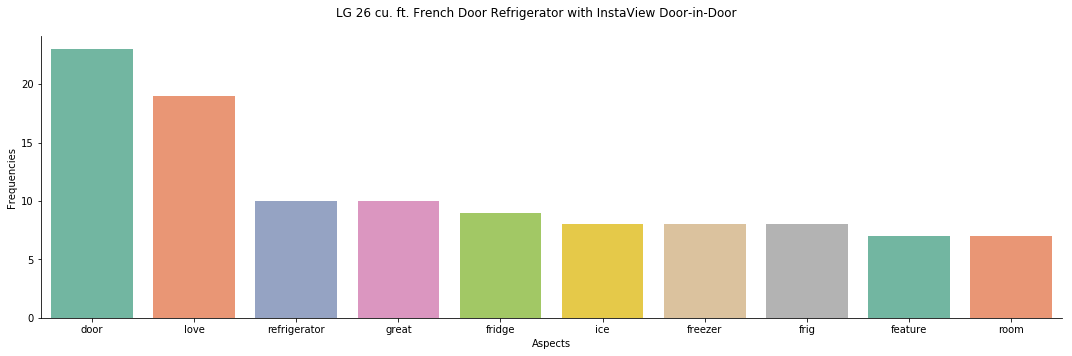

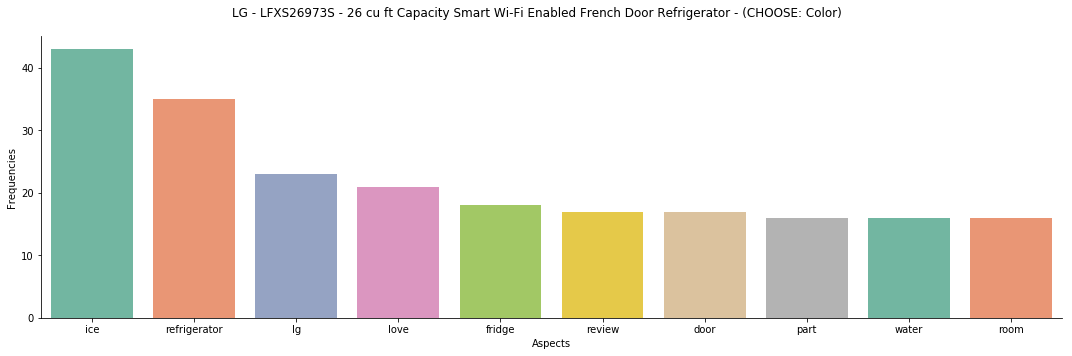

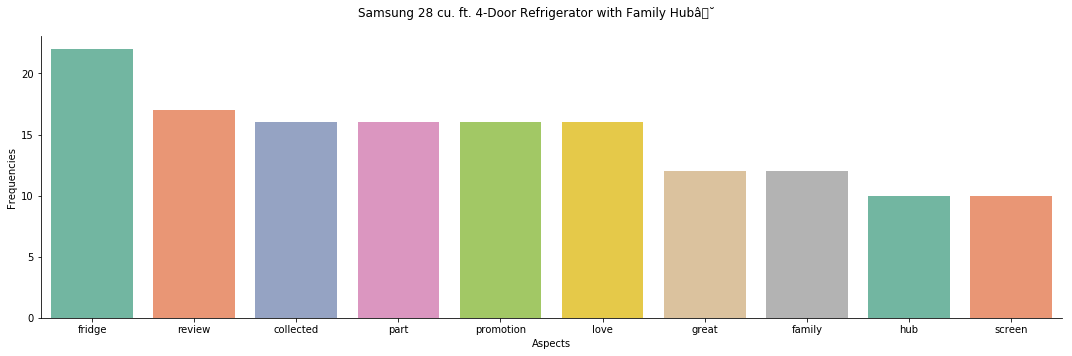

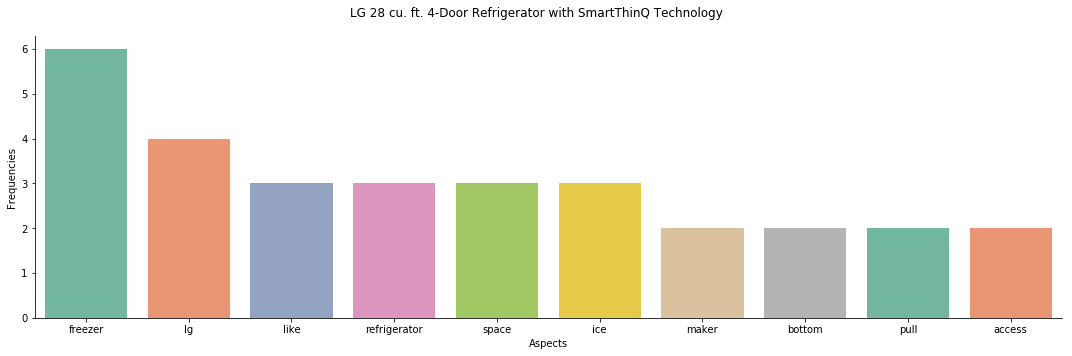

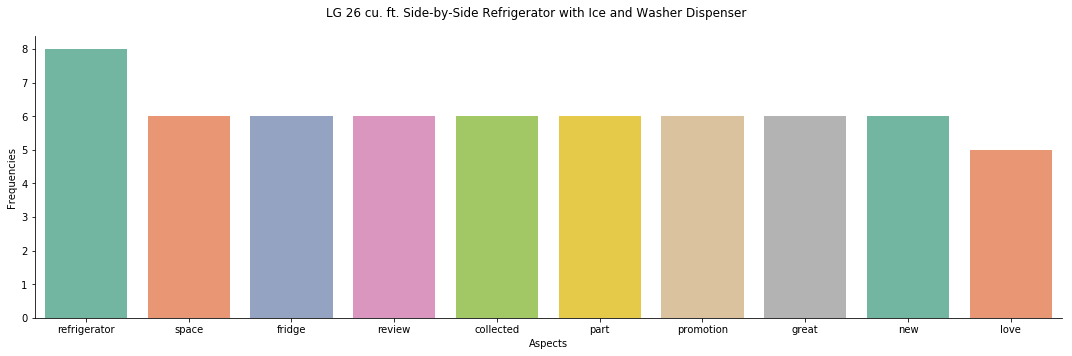

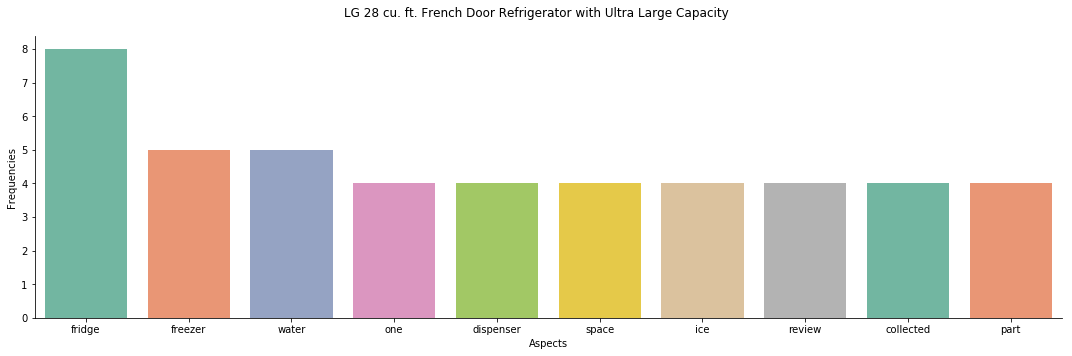

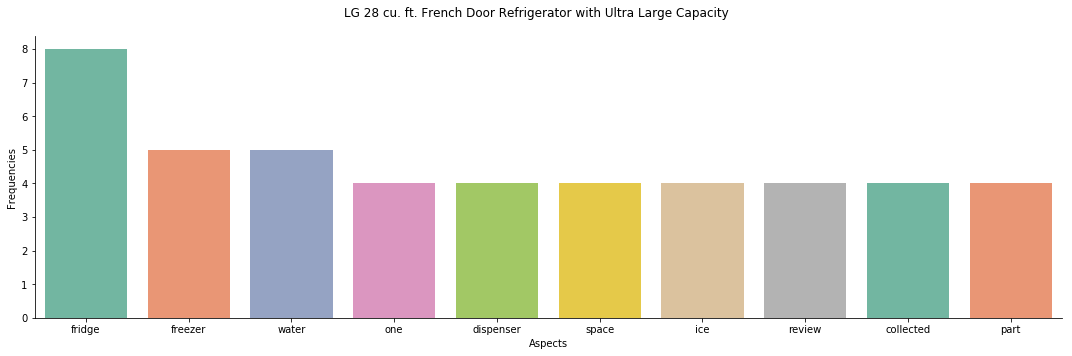

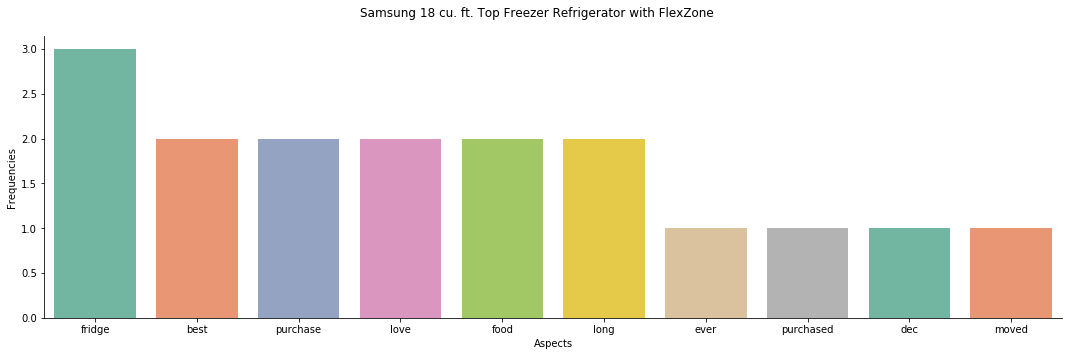

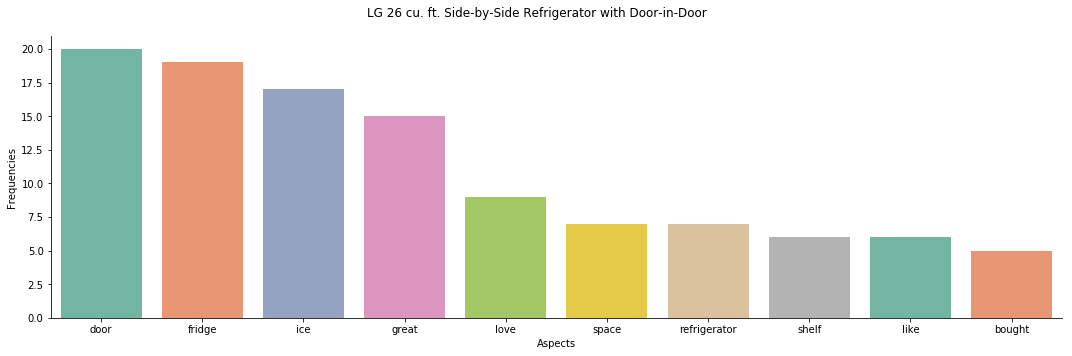

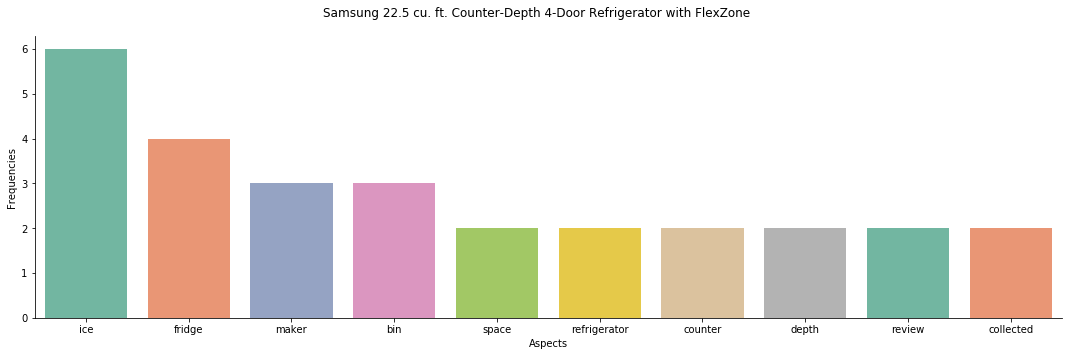

In [14]:
# Given the list of aspects identified in the test set
aspects = []
aspects_terms = codecs.open('output/aspect_terms', 'r', 'utf-8')
for l in aspects_terms:
    aspects.append(l.strip())

# Select all positive ratings
positive_ratings = data.loc[data['review_user_rating'] > 3] 

# Count every time a product is the target of a review
products = Counter()
for index, row in positive_ratings.iterrows():
    sku = row['offer_sku']
    products[sku] += 1

# Select the 10 most well rated products
most_well_rated_prod = sorted(products, key=lambda x:x[1], reverse=True)[:10]

# Recover all aspects related to each product with their frequences as well
aspects_for_prod = []
for prod in most_well_rated_prod:
    prod_reviews = data.loc[data['offer_sku'] == prod, 'review_title':'review_body']
    aspct = find_aspects(prod_reviews, aspects)
    aspct = sorted(aspct.items(), key=lambda x:x[1], reverse=True)[:10]
    aspects_for_prod.append(aspct)

# Plot an histogram for each product with the aspects frequences
for prod, sku in zip(aspects_for_prod, most_well_rated_prod):
    name = data.loc[data['offer_sku'] == sku, 'offer_title']
    df = pd.DataFrame(prod, columns=['Aspects', 'Frequencies'])
    
    ax = sns.catplot(x='Aspects', y='Frequencies', data=df, kind='bar', aspect=3, palette='Set2')
    ax.fig.suptitle(name.iloc[0])
    plt.subplots_adjust(top=0.9)

### 5.2. Aspects' positive mentions over time
For a set of frequent aspects in positive reviews, show how many times they are mentioned over time, for each month in the 2019/2020 interval.

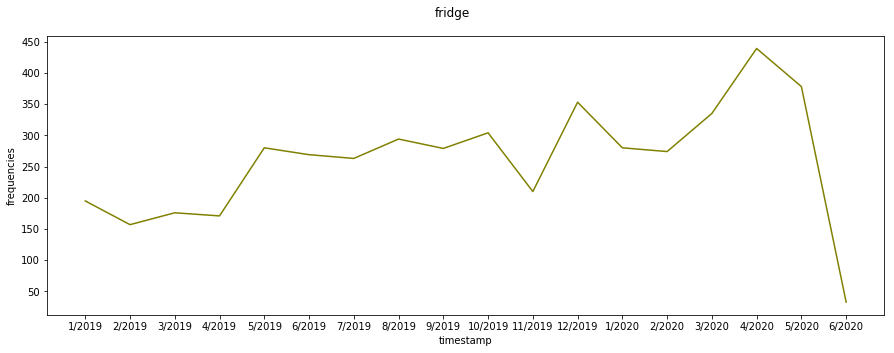

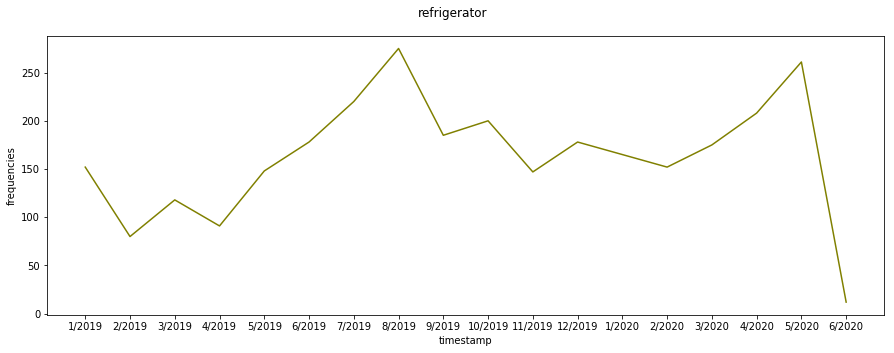

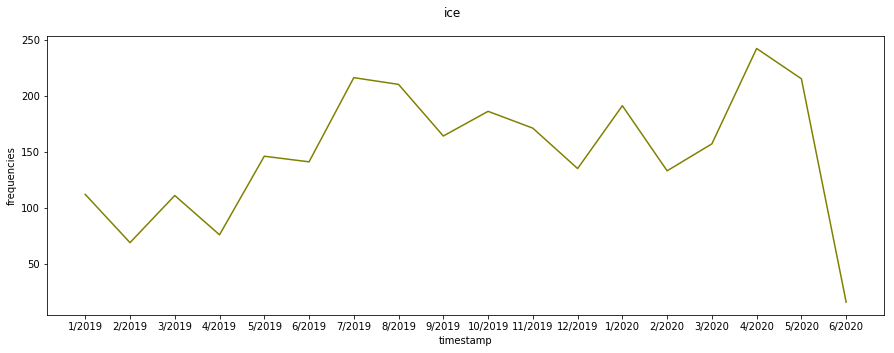

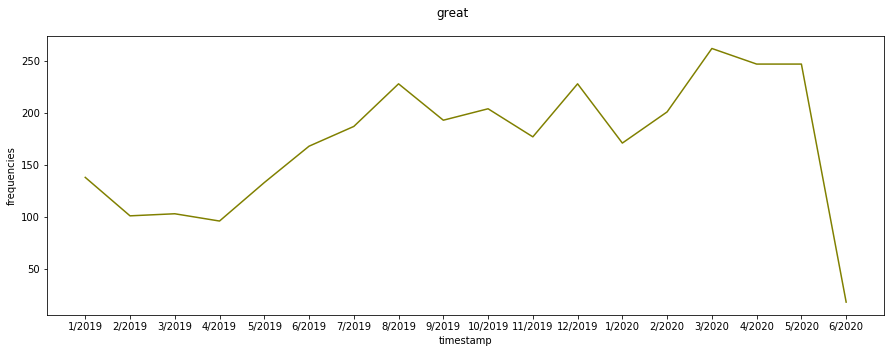

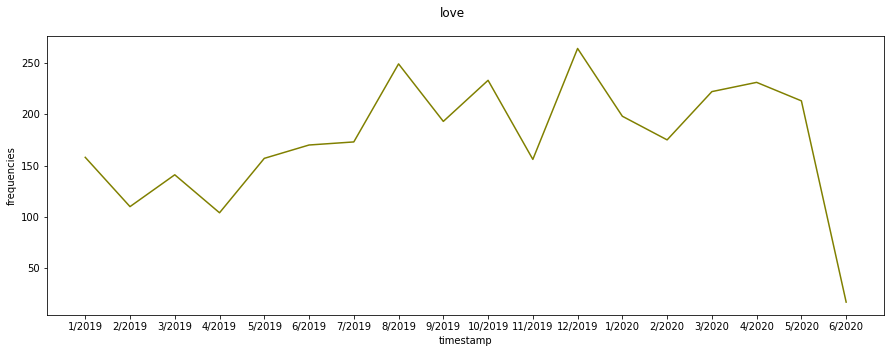

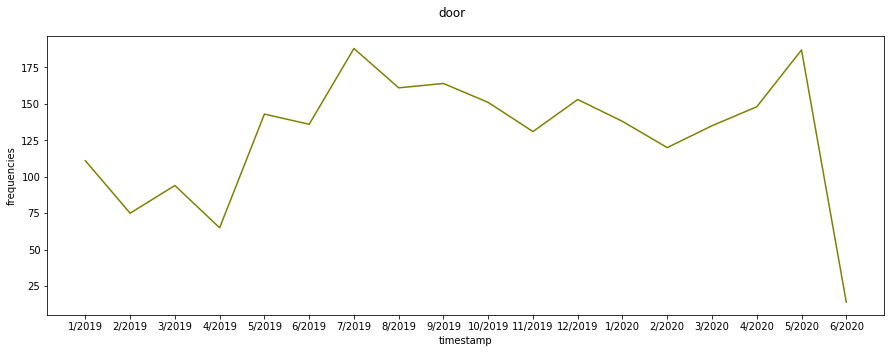

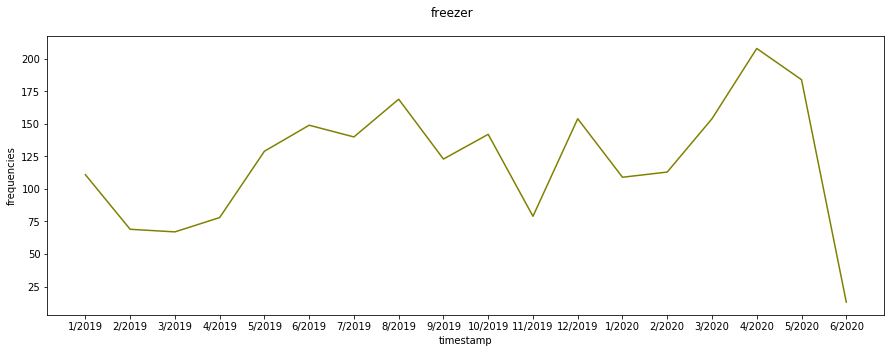

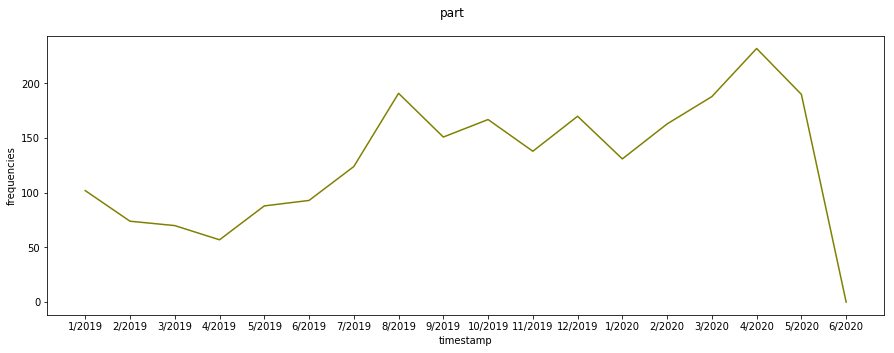

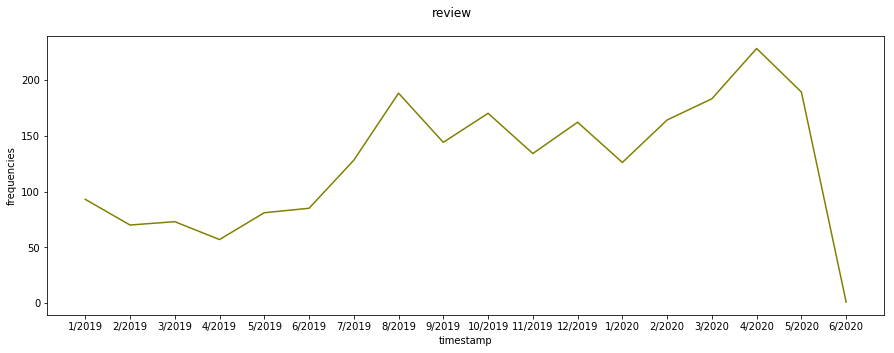

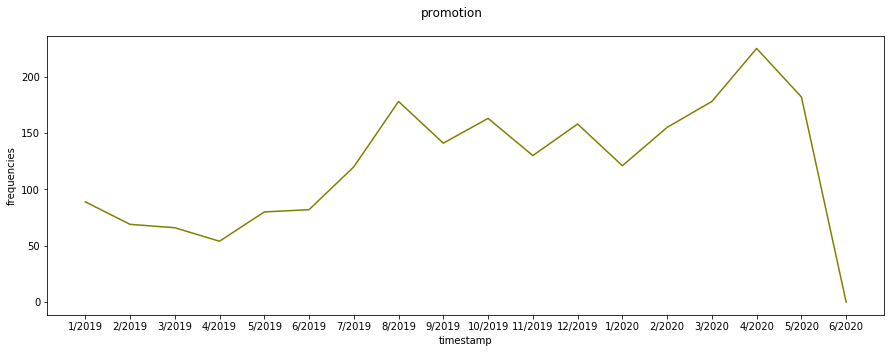

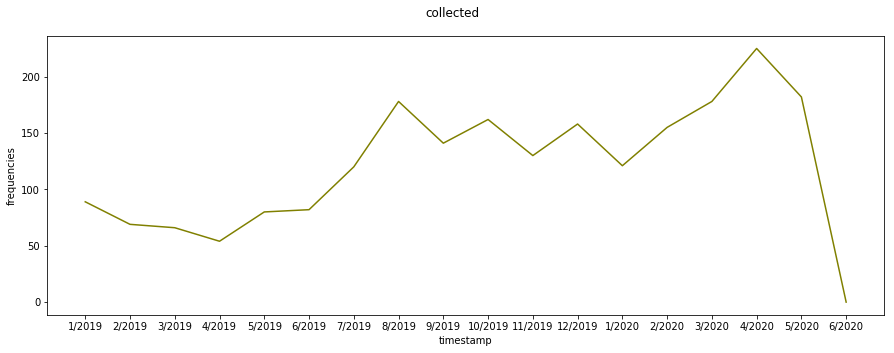

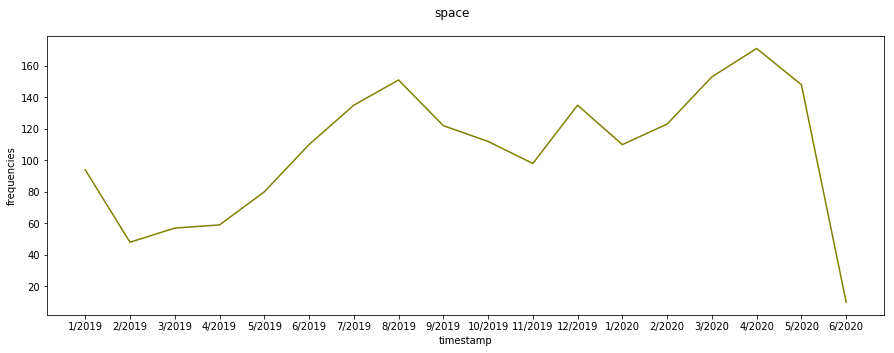

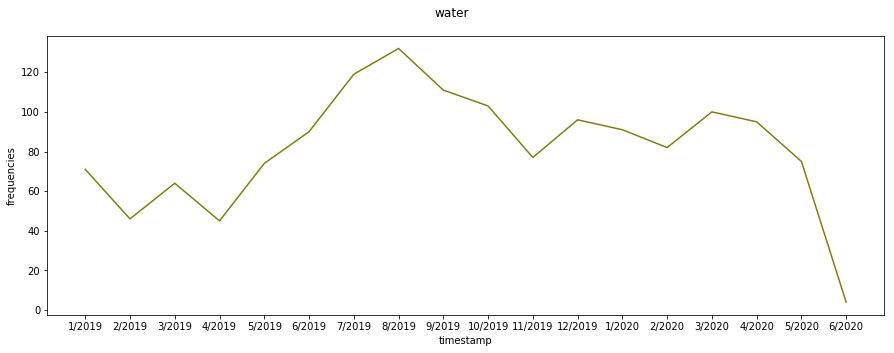

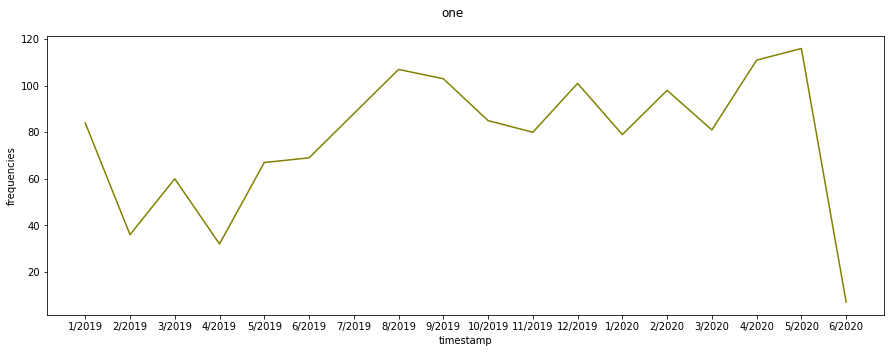

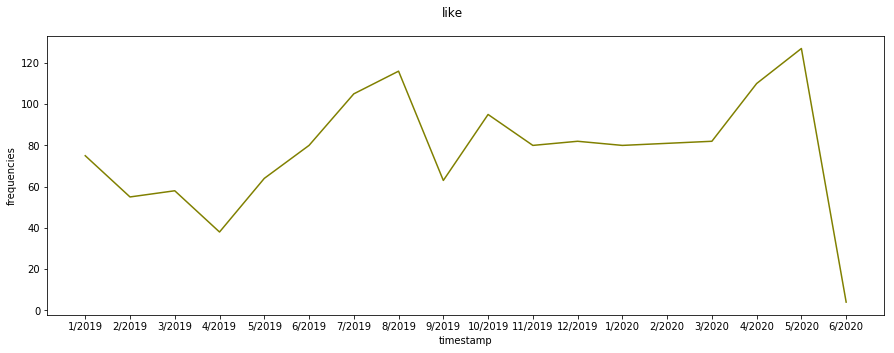

In [21]:
# Select all positive ratings
positive_ratings = data.loc[data['review_user_rating'] > 3] 

# Get the review cols and count frequent aspects given these reviews
positive_reviews = data.loc[:,'review_title':'review_body']
positive_aspects = find_aspects(positive_reviews, aspects)

# Select the 15 most frequent aspects
positive_aspects = sorted(positive_aspects.items(), key=lambda x:x[1], reverse=True)[:15]
positive_aspects = [w for w,_ in positive_aspects]

# Get the frequency of each aspect over time and build a DataFrame 
freq_over_time = {w:{} for w in positive_aspects}
freq_over_time['timestamp'] = {}
for y in [2019,2020]:
    year = positive_ratings.loc[positive_ratings['review_year'] == y]
    for m in range(1,13):
        month = year.loc[year['review_month'] == m]
        month_reviews = month.loc[:,'review_title':'review_body']
        month_aspects = find_aspects(month_reviews, positive_aspects)
        
        # There are no reviews in this dataset from 07/2020 
        if not (y == 2020 and m > 6): 
            m_y = str(m) + '/' + str(y)
            freq_over_time['timestamp'][m_y] = m_y
            for aspect in positive_aspects:
                if not aspect in month_aspects.keys():
                    freq_over_time[aspect][m_y] = 0
                else:
                    freq_over_time[aspect][m_y] = month_aspects[aspect]
time = pd.DataFrame.from_dict(freq_over_time)

# Plot the DataFrame 
for asp in positive_aspects:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(ax=ax, x=time['timestamp'], y=time[asp], color='olive', sort=False)
    fig.suptitle(asp)
    ax.set(ylabel='frequencies')
    plt.subplots_adjust(top=0.9)
    
## To vizualize all aspects at once ##

# fig, ax = plt.subplots(figsize=(15,5))
# for asp in positive_aspects:
#     sns.lineplot(ax=ax, x=time['timestamp'], y=time[asp], color='olive', sort=False)
#     fig.suptitle(asp)
#     ax.set(ylabel='frequencies')
#     plt.subplots_adjust(top=0.9)

## 6. Citation
[An unsupervised neural attention model for aspect extraction](https://www.aclweb.org/anthology/P17-1036)<br>
He, Ruidan, Wee Sun Lee, Hwee Tou Ng, and Daniel Dahlmeier.<br>
In Proceedings of the 55th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pp. 388-397. 2017.